# Gradient Boosting - From Scratch

# 1. Get data

In [1]:
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boston = load_boston()
X = boston.data
y = boston.target

In [5]:
# print(boston.DESCR)

# 2. Start with an initial prediction
- e.g. "bad model/ first guess"
- average

In [17]:
y0 = np.repeat(y.mean(), len(y))
# y0 = np.array([y.mean()] * len(y))

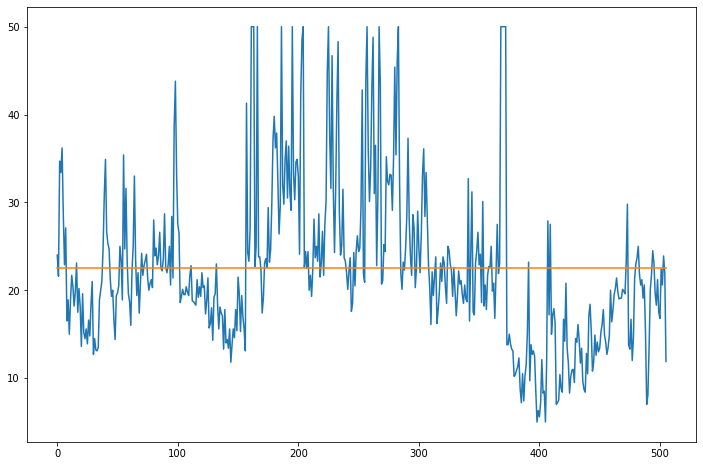

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(y)
plt.plot(y0)

# 3. Write an error function

$$loss = \frac{( y-\hat{y})^2}{2}$$

In [22]:
def compute_error(y, yhat):
    
    """y and y_hat are single numbers"""
    
    return (y - yhat)**2 / 2

In [25]:
compute_error(y, y0).mean()

42.20977807808278

# 4. Visualize error gradient (recap of gradient descent)

In [27]:
y0[0]

22.532806324110677

In [30]:
y[0]

24.0

In [31]:
losses = []
for i in np.arange(-2, 2, 0.01):
    
    error = compute_error(y[0], y0[0] + i)
    losses.append(error)

Text(0.5, 1.0, 'Error for JUST THE FIRST POINT')

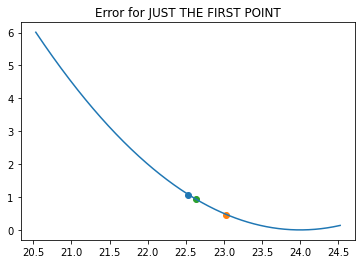

In [36]:
plt.scatter(y0[0], compute_error(y[0], y0[0]))
plt.scatter(y0[0] + 0.5, compute_error(y[0], y0[0] + 0.5))
plt.scatter(y0[0] + 0.1, compute_error(y[0], y0[0] + 0.1))
plt.plot(y0[0] + np.arange(-2, 2, 0.01), losses)
plt.title('Error for JUST THE FIRST POINT')

In [37]:
delta_x = 0.1
delta_y = (compute_error(y[0], y0[0] + 0.1)) - (compute_error(y[0], y0[0]))

slope = delta_y / delta_x
slope


-1.4171936758893422

# 5. Calculate the derivative of the error function
- For convenience

$$error = \frac{( y-\hat{y})^2}{2}$$

$$\frac{\delta (error)}{\delta \hat{y}}  = -1*( y-\hat{y})$$

In [38]:
def error_gradient(y, yhat):
    
    return -(y - yhat)

In [40]:
# error_gradient(y, y0)

# 6. Calculate pseudo-residuals

In [41]:
pseudo_residuals = -error_gradient(y, y0)

# 7. Train a weak learner to predict pseudo-residuals

In [42]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(max_depth=1)
regressor.fit(X, pseudo_residuals)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

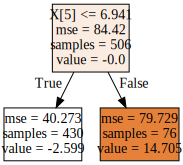

In [43]:
from sklearn.tree import export_graphviz
import graphviz

tree = export_graphviz(regressor, out_file=None, filled=True)
open('boston.dot', 'w').write(tree)
graph = graphviz.Source(tree)
graph

In [45]:
# print(boston.DESCR)

# 8. Make new predictions

In [46]:
y1 = y0 + regressor.predict(X)

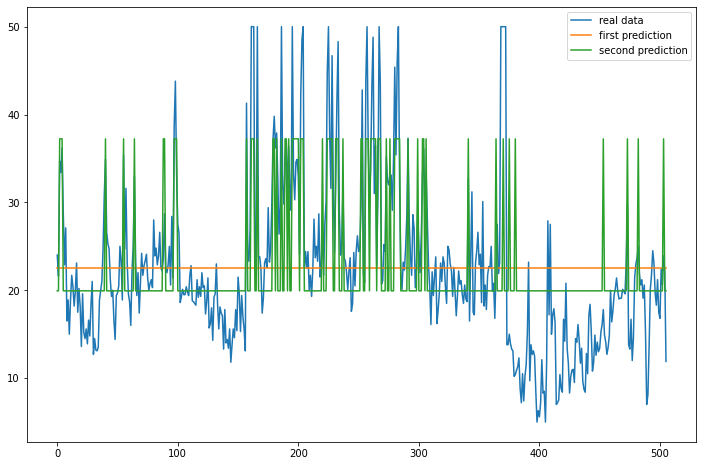

In [48]:
plt.figure(figsize=(12, 8))
plt.plot(y)
plt.plot(y0)
plt.plot(y1)
plt.legend(['real data', 'first prediction', 'second prediction'])

In [50]:
compute_error(y, y1).mean()

23.09954583855424

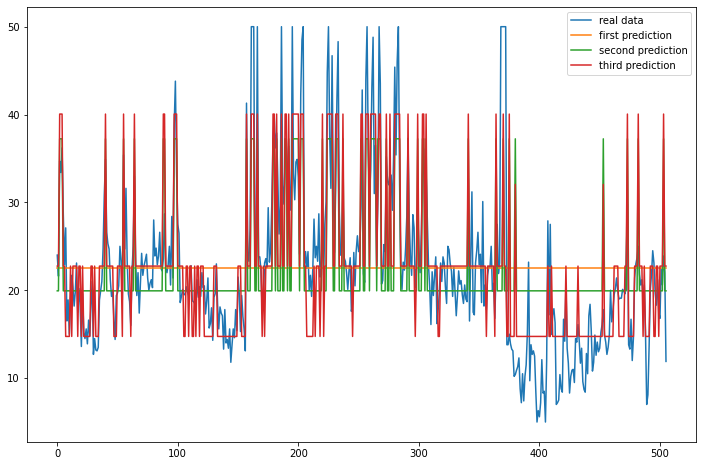

In [52]:
### SECOND ITERATION

pseudo_residuals = -error_gradient(y, y1)
regressor.fit(X, pseudo_residuals)
y2 = y1 + regressor.predict(X)


plt.figure(figsize=(12, 8))
plt.plot(y)
plt.plot(y0)
plt.plot(y1)
plt.plot(y2)
plt.legend(['real data', 'first prediction', 'second prediction', 'third prediction'])

# 9. Repeat steps 6-9 iteratively in a loop

In [58]:
def gradient_boost(X, y, n):
    
    """Gradient Boosted Tree Algorithm (simple)"""

    #Step1 - initial prediction
    yhat = np.repeat(y.mean(), len(y))
    
    regressors = []
    
    y0 = yhat
    
    for i in range(n):
        
        #Calculate pseudo-residuals
        pseudo_residuals = -error_gradient(y, yhat)
        
        #Train a weak tree (stump)
        regressor = DecisionTreeRegressor(max_depth=1)
        regressor.fit(X, pseudo_residuals)
        
        #Add the prediction to the old prediction
        yhat = yhat + regressor.predict(X)
        
        #collect the trained models as we go:
        regressors.append(regressor)
        
#         print(compute_error(y, yhat).mean())

    return regressors, y0

In [59]:
regressors, initial_prediction = gradient_boost(X, y, 100)

# 10. Use ensemble of weak learners to make new predictions.

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [62]:
def gb_predict(regressors, y0, X):
    
    """Takes the pre-trained ensemble of weak trees from training step and use them in SERIES to make 
    predictions on new data."""
    
    yhat = np.repeat(y0[0], len(X))
    
    for r in regressors:
        
        yhat = yhat + r.predict(X)
        
    return yhat

In [63]:
### STEP1: TRAIN
regressors, y0 = gradient_boost(X_train, y_train, 100)

### STEP2: PREDICT
prediction = gb_predict(regressors, y0, X_test)

In [64]:
compute_error(y_test, prediction).mean()

7.021083308468542

Overfitting! 
- not too bad for a first attempt

Gradient Boosting is a "greedy algorithm" and can overfit training data quickly. To reduce:
- Tree constraints (n_estimators, max_depth)
- Play around with weight values / gamma (learning rate)
- Stochastic Gradient Boosting (random subsamples of the data)
- Penalized Gradient Boosting (Regularization)

### Visualize final result

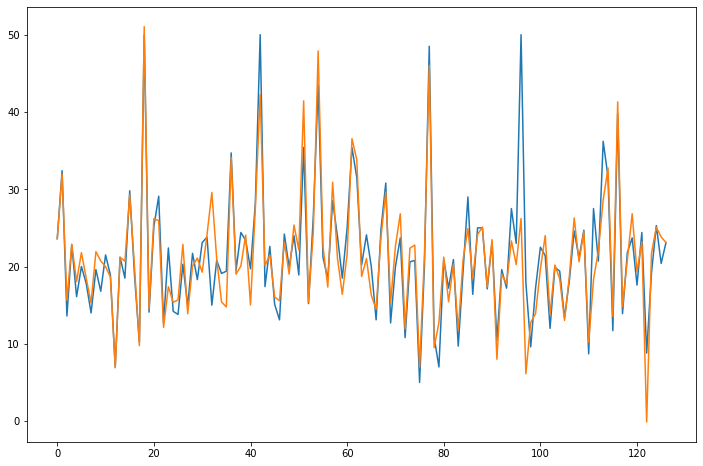

In [65]:
plt.figure(figsize=(12, 8))
plt.plot(y_test)
plt.plot(prediction)

### Python Implementations 

1. Catboost (Yandex) - 2017

2. LightGBM (Microsoft) - 2016

3. XGBoost (open-source) - 2014

**Final thoughts:**
- In gradient descent, you tweak the parameters iteratively to reduce the gradient.
- In gradient boosting, you add more models in series iteratively to reduce the gradient.